### Сбор данных и динамический анализ позиций в поиске по артикулам для определенного бренда на Вб в разрезе запросов

__Цель:__ написать код, котрый будет отслеживать позиции в поиске ВБ в режиме реального времени (при запуске блокнота), в зависимости от запроса и количества страниц. Автоматизировать почасовой сбор данных, наглядно показать результаты. 

Данная работа поможет менеджеру бренда своевременно заметить выпад в поиске с первых страниц или с конкретных запросов, отследить резкие изменения позиций и своевременно принять меры.

Для исследования были выбраны:
- ниша - купальники для гимнастики
- бренд 'НОЛА'
- интересует первая страница

Данные о позициях были получены через открытое API площадки ВБ.

In [1]:
# Импортируем необходимые библиотеки
import requests
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt

In [2]:
# Запрсы, по которым будем определять позиции в поиске
query_list=['купальник гимнастический', 'купальник для танцев', 'купальник для хореографии']
# Количество страниц, которые интересуют для просматривания позиций
max_page = 1 
# рассматриваемый бренд 
brand='НОЛА'

In [3]:
search_list=[]
# получаем необходимые данные по открытому API ВБ
# цикл по заданным запросам
for query in query_list:
    #print(f'\nЗапрос:{query}')
    cnt=0
# цикл по заданным страницам
    for page in range(1,max_page+1):
        #print(f'\nстраница {page}')
        res = requests.get(f'''
        https://search.wb.ru/exactmatch/ru/common/v13/search?ab_testing=false&appType=64&curr=rub&dest=123585762&\
        hide_dtype=13&lang=ru&page={page}&query={query}&resultset=catalog&sort=popular&spp=30&suppressSpellcheck=false''')
        products=res.json()['data']['products']
# цикл по товарам заданного бренда
        for product in products:
            cnt+=1
            if product['brand'] == brand:
                dt=datetime.today()
                #print(product['id'], product['name'])
                for size in product['sizes']:
                    search_list.append([dt, query, cnt, product['id'], product['name'], size['name'], size['price']['product']])
                

In [4]:
# оформим результат в таблицу
import pandas as pd
df=pd.DataFrame(search_list)
df.columns=['date', 'query', 'position', 'id', 'name', 'size', 'price']
df['price']=round(df['price']/100,0).astype('int')
df['date'] = pd.to_datetime(df['date']).dt.floor('s')
#df

In [5]:
# сгруппируем позиции в поиске по артикулу, запросу и городу
df_group=df.groupby(['id','query']).agg({'position':'min', 'price':'mean', 'size':'nunique'})
display(df_group)
df_group=df_group.reset_index()

position   price  size
id        query                                            
8881424   купальник гимнастический         24   996.0     7
10073304  купальник гимнастический         38   996.0     7
          купальник для танцев             60   996.0     7
10743190  купальник гимнастический         33  1243.0     7
          купальник для танцев             56  1243.0     7
          купальник для хореографии        28  1243.0     7
13254144  купальник для хореографии        81   917.0     6
13254145  купальник для хореографии        11   986.0     6
13254146  купальник для хореографии        95   590.0    10
13254147  купальник для хореографии        66   634.0     9
13254312  купальник гимнастический          3   618.0     9
          купальник для танцев              5   618.0    10
          купальник для хореографии        13   618.0     9
13254313  купальник для хореографии        49   740.0    10
13254314  купальник для хореографии        97   740.0    10
14653151  купальник гимнастический         55  1243.0     7
          купальник для хореографии        42  1243.0     7
37054479  купальник гимнастический         71   841.0     5
171605777 купальник гимнастический         42   996.0     7
          купальник для танцев             73   996.0     7
182876073 купальник гимнастический         56   905.0     7
          купальник для танцев             64   905.0     7
          купальник для хореографии        47   905.0     7
182876074 купальник для хореографии        87   942.0     7
205031070 купальник гимнастический         35   679.0     7
205329077 купальник для танцев             34   708.0    10

In [6]:
# Сводная таблица позиций в поиске в зависимости от запроса
table_query=df_group.pivot_table(index='id', columns='query', values='position',aggfunc='min').reset_index().round(1)
print('\n','='*100,'\nСводная таблица позиций в поиске в зависимости от запроса\n')
display(table_query)

# Сводная таблица цен
table_price=df.groupby(['id'])[[ 'price','position']].mean().head(60).reset_index()
table_price[['price','position']]=table_price[['price','position']].round(2)


Сводная таблица позиций в поиске в зависимости от запроса



query,id,купальник гимнастический,купальник для танцев,купальник для хореографии
0,8881424,24.0,NaN,NaN
1,10073304,38.0,60.0,NaN
2,10743190,33.0,56.0,28.0
3,13254144,NaN,NaN,81.0
4,13254145,NaN,NaN,11.0
5,13254146,NaN,NaN,95.0
6,13254147,NaN,NaN,66.0
7,13254312,3.0,5.0,13.0
8,13254313,NaN,NaN,49.0
9,13254314,NaN,NaN,97.0


Всего артикулов: 17


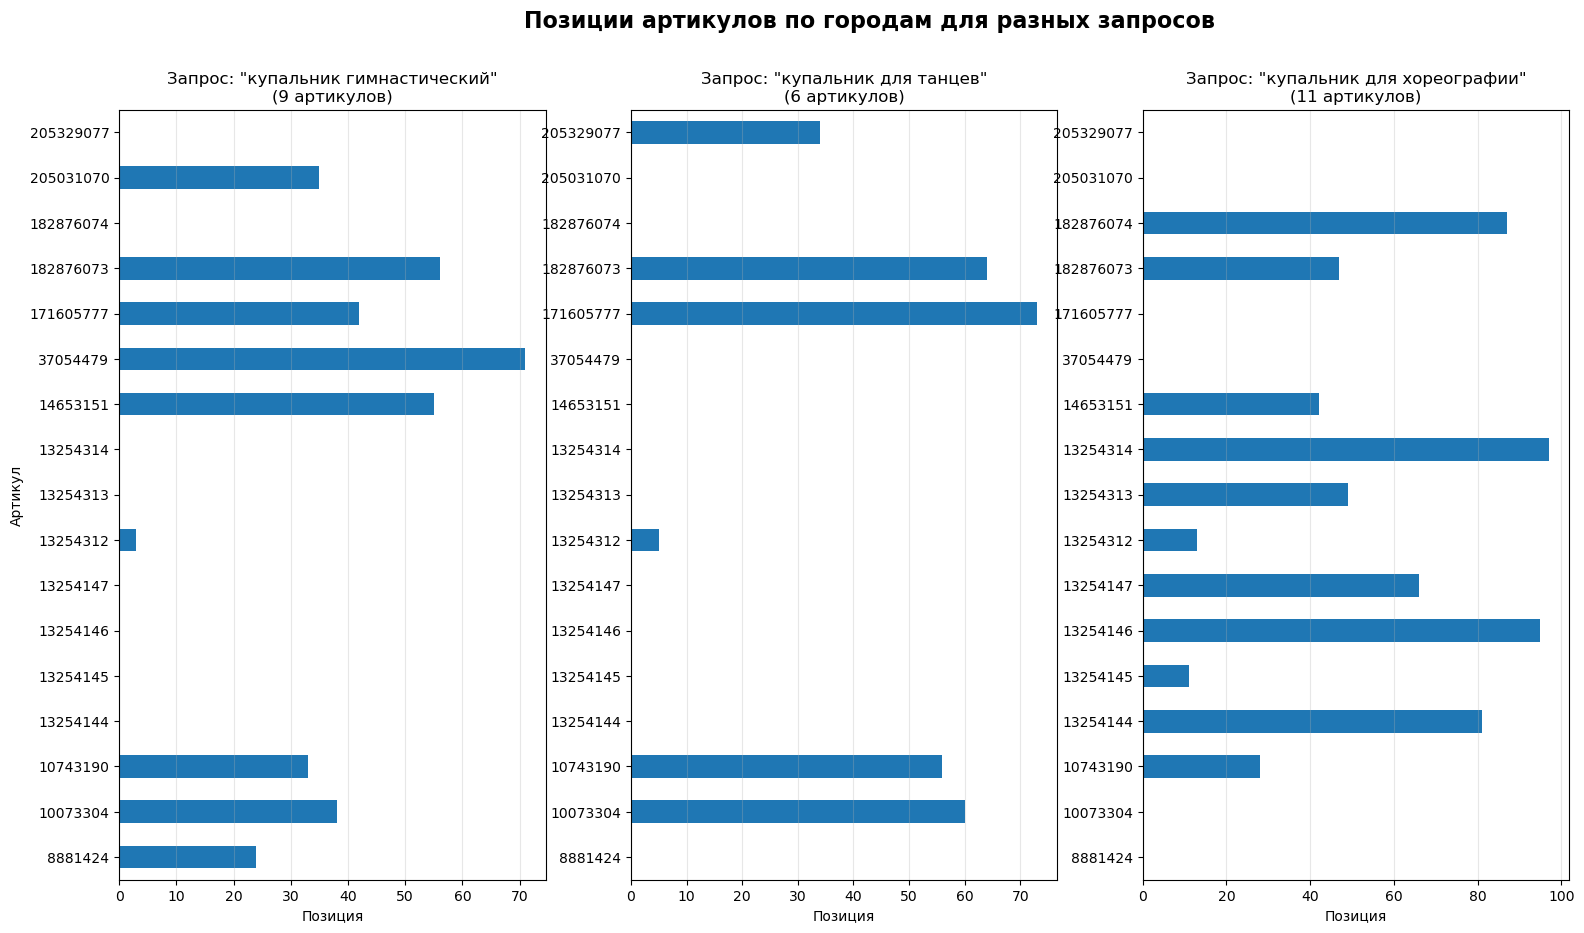

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Позиции артикулов по городам для разных запросов', fontsize=16, fontweight='bold')

# Собираем  артикулы 
all_articles = sorted(df['id'].unique())

print(f"Всего артикулов: {len(all_articles)}")

# Строим графики для каждого запроса
for i, query in enumerate(query_list):
    # Фильтруем данные по запросу
    df_query = df[df['query'] == query]
    
    # Создаем таблицу: артикулы vs позиции
    table = df_query.groupby('id')['position'].mean().round(1)
    
    # созаем новую пустую таблицу с правильным порядком артикулов 
    new_table = pd.DataFrame(index=all_articles, columns=['Позиция'])
    
    # Заполняем данными из исходной таблицы
    for article in all_articles:
        if article in table.index:
            new_table.loc[article, 'Позиция'] = table.loc[article]
    
    # Строим горизонтальные столбчатые диаграммы
    new_table.plot(kind='barh', ax=axes[i], legend=False)
    axes[i].set_title(f'Запрос: "{query}"\n({len(df_query["id"].unique())} артикулов)')
    axes[i].set_xlabel('Позиция')
    axes[i].grid(axis='x', alpha=0.3)
    
    # Настраиваем подписи артикулов
    axes[i].set_yticklabels(new_table.index)

axes[0].set_ylabel('Артикул')
plt.subplots_adjust(right=0.85)
plt.show()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;">  Из гистограммы, представленной выше, можно увидеть, как меняется позиция в поиске для покупателя: какие артикулы и по каким запросам выпадают. Также в целом видно, какие из артикулов бренда находится выше или ниже в поисковой выдаче. Подробнее можно изучить в сводной таблице позиций по городам, представленной выше.

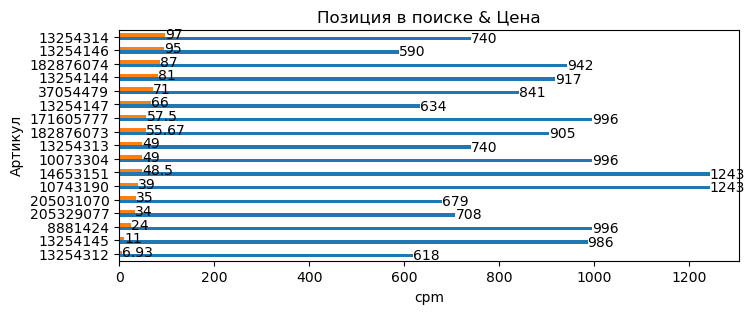

In [8]:
# Пострим линейную гстограмму по цене 
#try:
ax=table_price.sort_values('position').plot(kind='barh',
              x='id',
              y= ['price', 'position'],
              figsize=(8,3),
              legend=False,
              rot=0
)
plt.title('Позиция в поиске & Цена')

plt.xlabel('cpm')
plt.ylabel('Артикул')
plt.bar_label(ax.containers[0]) 
plt.bar_label(ax.containers[1])
plt.show()


<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Гистограмма, представленная выше, отражает цены артикулов и место в поиске, для того, чтобы посмотреть визуально, есть ли связь между ценой и местом в поиске.

## Динамический анализ данных

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> На основании кода выше был написан гугл скрипт. Каждый час данные автоматизировано складывались в гугл таблицу. Дальнейший анализ выполнен на основании этого датасета за 3 полных дня (05.10.2025-07.10.2025).

In [9]:
# Импортируем данные из таблицы и выведем первые 5 строк
df_post=''
url = 'https://docs.google.com/spreadsheets/d/1WPd--MqyEQJCCRjFjJxLjAFDOupccu4DYq8at6xXbMg/export?format=csv'
df_post = pd.read_csv(url)
df_post.columns=['datetime', 'query', 'city', 'position', 'id', 'name', 'size', 'price']
df_post['datetime'] = pd.to_datetime(df_post['datetime'], format='%d.%m.%Y %H:%M:%S')
df_post['date']=df_post['datetime'].dt.date
df_post['time'] = df_post['datetime'].dt.floor('h').dt.time
df_post.head()

,datetime,query,city,position,id,name,size,price,date,time
0,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,104,565,2025-10-04,17:00:00
1,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,110,565,2025-10-04,17:00:00
2,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,116,565,2025-10-04,17:00:00
3,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,122-128,565,2025-10-04,17:00:00
4,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,134,565,2025-10-04,17:00:00


In [10]:
# группируем данные по запросу, артикулу, дате и часу
df_pos_group=df_post.groupby(['date','time','query','id'])[['position','price']].mean().reset_index()
df_pos_group[['position','price']] = df_pos_group[['position','price']].astype(int)
list_id=df_pos_group.sort_values('position')['id'].unique()

Как меняется позиция в поиске по артикулам и запросам в течение 24 часов в разрезе трех дней


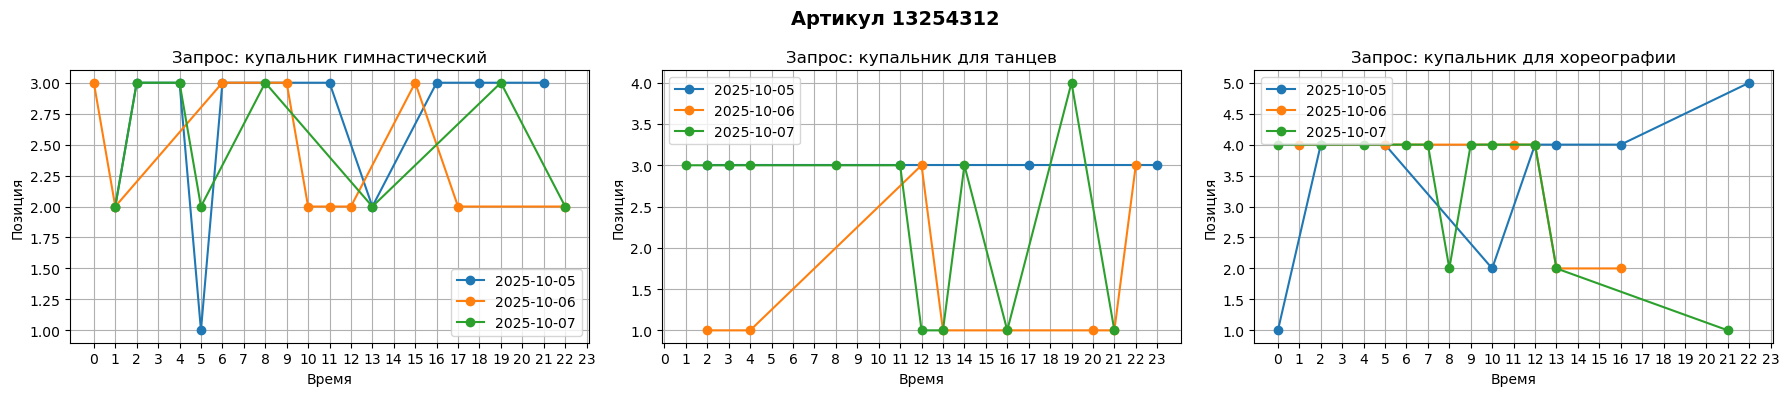

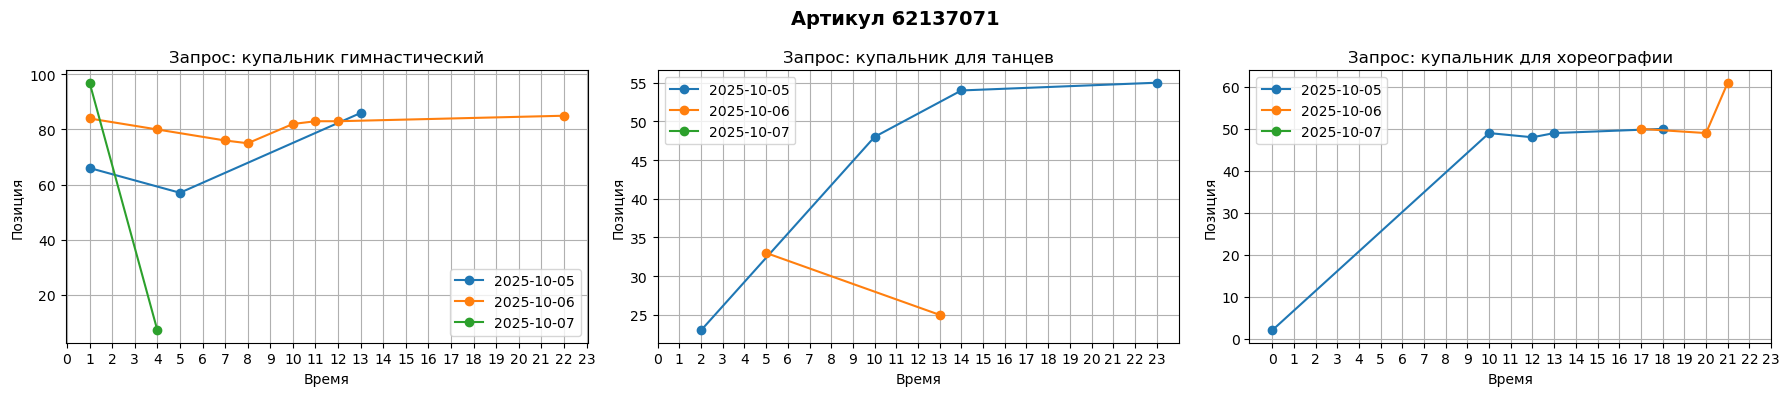

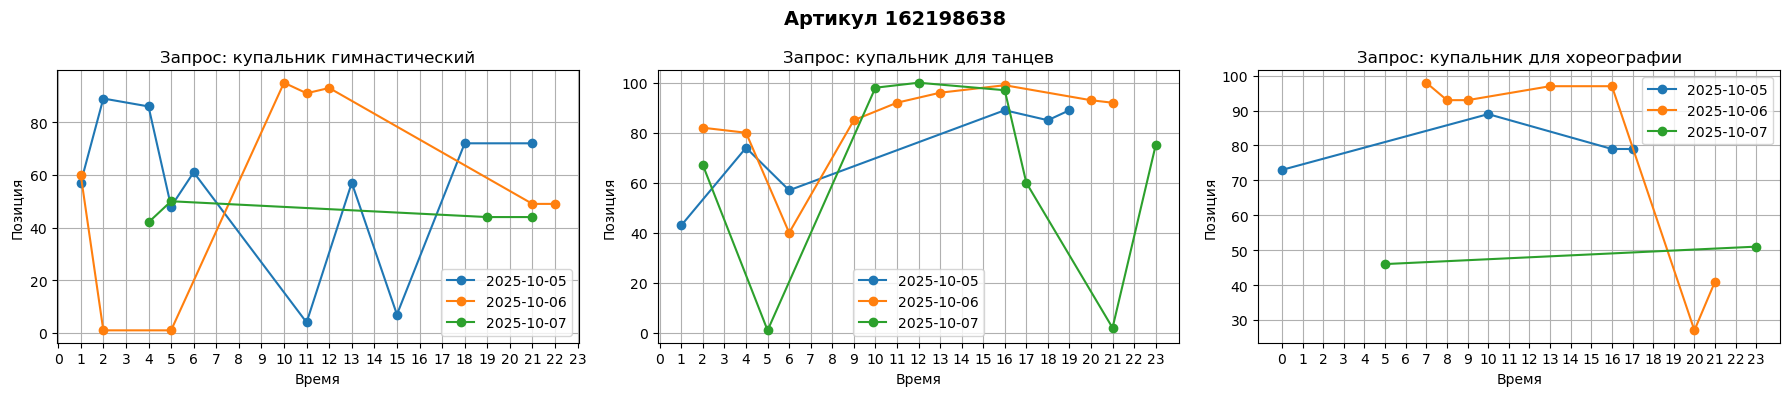

In [11]:
# строим график 
print('\033[1mКак меняется позиция в поиске по артикулам и запросам в течение 24 часов в разрезе трех дней\033[0m')
dates = pd.date_range(start='2025-10-05', end='2025-10-07', freq='D').date.tolist()
for id_ in list_id[0:3]:
    df_pos_group1 = df_pos_group[df_pos_group['id'] == id_]
    print('='*150)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 строка, 3 столбца
    fig.suptitle(f'Артикул {id_}', fontsize=14, fontweight='bold')
    
    for i, que in enumerate(query_list):  # enumerate дает индекс i для каждого запроса
        df_pos_group2 = df_pos_group1[df_pos_group1['query'] == que]
       
        for date in dates:  
            data = df_pos_group2[df_pos_group2['date'] == date]
            hours = [t.hour for t in data['time']]
            axes[i].plot(hours, data['position'], marker='o', label=date)
        
        axes[i].set_xlabel('Время')
        axes[i].set_ylabel('Позиция')
        axes[i].set_title(f'Запрос: {que}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_xticks(range(0, 24))
        
    plt.tight_layout()  
    plt.show()
    plt.close()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> На графике выше наглядно видна динамика в течение дня,  для некоторых арт происходят сильные изменения позиции: они могут падать, вылетать  вообще с первых 100 мест, с конкретных запросов. Также можно сравнить как позиции различаются в каждый из 3 дней и одинаковый ли тренд в течении дня у одного артикула, но по разным запросам. Есть товары, которые поднимаются в поиске в ночное время, днем снова падают. Данные (для экономии места) представлены только по 3 артикулам, занимающим верхние места в поиске.

 Позиции в поиске для артикулов с максимальным изменением в течении дня за 06.10.2025


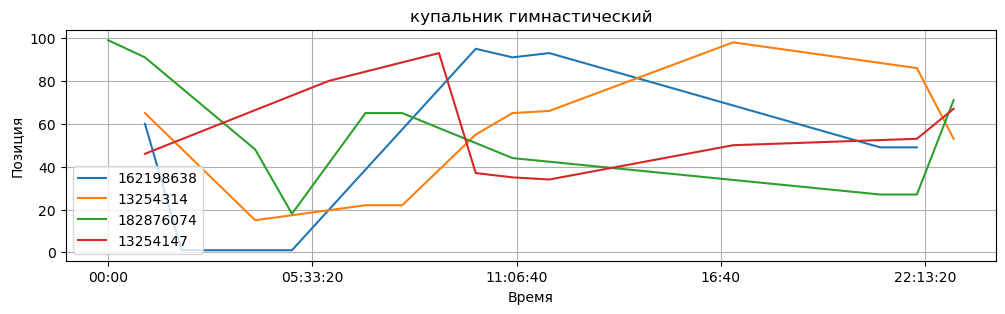

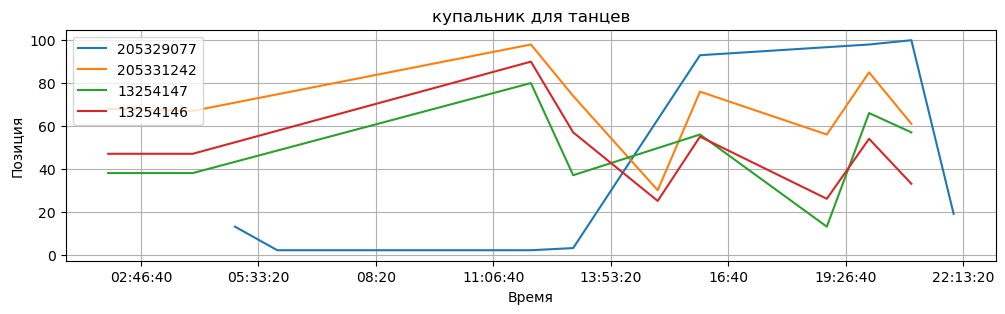

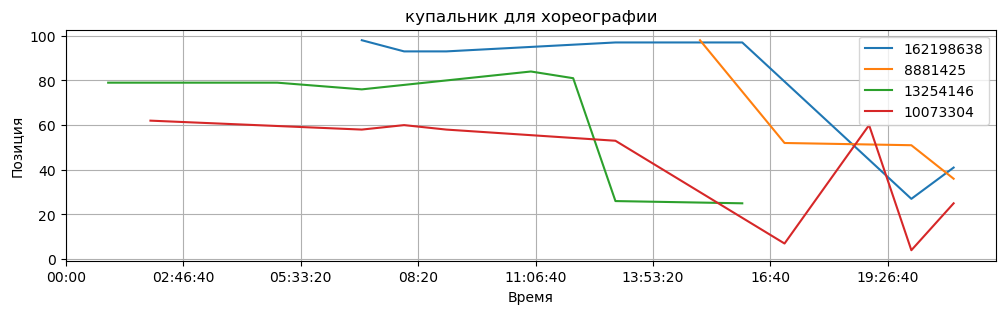

In [12]:
print('\033[1m Позиции в поиске для артикулов с максимальным изменением в течении дня за 06.10.2025\033[0m')
df_day = df_pos_group[df_pos_group['date'].astype(str) == '2025-10-06']
for que in query_list:
    df_day1 = df_day[df_day['query'] == que]
    df_razm=df_day1.groupby('id')['position'].agg(['min','max']).reset_index()
    df_razm['razm']=df_razm['max']-df_razm['min']
    df_razm=df_razm.sort_values('razm', ascending=False)
    list_id_r=df_razm['id'].unique()
    
    plt.figure(figsize=(12, 3))
    
    for id_ in list_id_r[0:4]:
        d = df_day1[df_day1['id'] == id_]
        if len(d) > 0:  # Если есть данные для этого id
            d.plot(kind='line', x='time', y='position', label=id_, ax=plt.gca())
    
    plt.xlabel('Время')
    plt.ylabel('Позиция')
    plt.title(que)
    plt.grid(True)
    plt.show()
    plt.close()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Графики выше демонстрируют изменения во времени в течении 1 дня по разным запросам, в данный набор попадают 4 артикула с максимальным изменением в поиске. Резкий отброс вниз поиска может свидетельствовать о том, что арт на определенное время вылетает из рекламных позиций, на это стоит обратить внимание. 